In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np
import os

# --- Define paths and constants ---
img_height, img_width = 224, 224
batch_size = 32
train_dir = "./dataset/train/"
val_dir = "./dataset/val/"

# --- Image Data Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

# --- Show class mapping and compute class weights ---
print("\nClass Indices:", train_gen.class_indices)
unique, counts = np.unique(train_gen.classes, return_counts=True)
print("Class Distribution:", dict(zip(unique, counts)))

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights_dict = dict(enumerate(class_weights))

# --- Transfer Learning with MobileNetV2 ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-6)

# --- Train Model ---
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights_dict
)

# --- Save Model ---
model.save("rice_weed_classifier_mobilenet.keras")
print("✅ Transfer learning model saved as rice_weed_classifier_mobilenet.keras")


Found 240 images belonging to 2 classes.
Found 45 images belonging to 2 classes.

Class Indices: {'rice': 0, 'weed': 1}
Class Distribution: {0: 116, 1: 124}
Epoch 1/10


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


1/8 [==>...........................] - ETA: 44s - loss: 0.7040 - accuracy: 0.5312

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


8/8 [==============================] - 21s 2s/step - loss: 0.4351 - accuracy: 0.7833 - val_loss: 0.2628 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 2/10
8/8 [==============================] - 15s 2s/step - loss: 0.0697 - accuracy: 0.9792 - val_loss: 0.1834 - val_accuracy: 0.9111 - lr: 0.0010
Epoch 3/10
8/8 [==============================] - 15s 2s/step - loss: 0.0612 - accuracy: 0.9875 - val_loss: 0.1697 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 4/10
8/8 [==============================] - 15s 2s/step - loss: 0.0165 - accuracy: 0.9958 - val_loss: 0.1179 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 5/10
8/8 [==============================] - 15s 2s/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.0933 - val_accuracy: 0.9778 - lr: 0.0010
Epoch 6/10
8/8 [==============================] - 16s 2s/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.0880 - val_accuracy: 0.9778 - lr: 0.0010
Epoch 7/10
8/8 [==============================] - 15s 2s/step - loss: 0.0146 - accuracy: 0.9958 - val_los

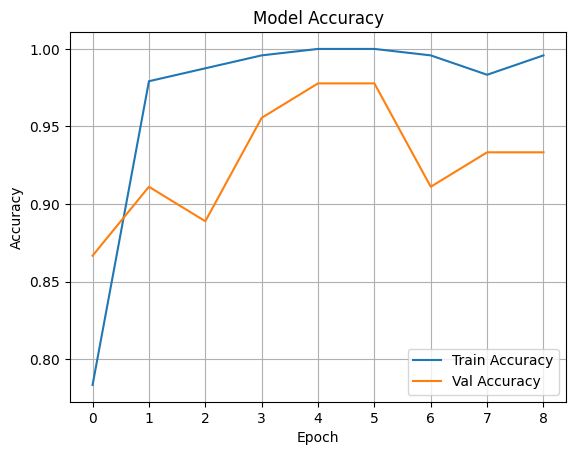

In [13]:
# Plot training history (accuracy)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()# Define early stopping and learning rate scheduler callbacks